# draw a Gantt chart using Python

In [1]:
import pandas
print(pandas.__version__)
import matplotlib.pyplot as plt
import matplotlib
print(matplotlib. __version__)
import datetime
import random
import time
import pickle
import sys
print(sys.version)

1.3.3
3.4.3
3.9.6 | packaged by conda-forge | (default, Jul 11 2021, 03:39:48) 
[GCC 9.3.0]


In [2]:
# https://wiki.python.org/moin/UsingPickle

with open("project.pkl", "rb") as file_handle:
    df = pickle.load( file_handle )

In [3]:
df

,ID,Duration in days,predecessor ID,successor ID,predecessor category,successor category,predecessor change in days,successor change in days
0,1,5,NaN,2,NaN,NaN,NaN,23.0
0,1,5,NaN,3,NaN,start-to-finish,NaN,8.0
1,2,12,5,4,NaN,NaN,NaN,NaN
2,3,6,4,NaN,finish-to-start,NaN,20.0,NaN
3,4,10,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# https://towardsdatascience.com/create-new-column-based-on-other-columns-pandas-5586d87de73d

def set_max(row, max_min_task_dict):
    return int(row['Duration in days'])+max_min_task_dict[row['ID']][1]
    
def set_min(row, max_min_task_dict):
    """
    if initial value is zero we don't want to decrease that
    """
    return max(int(row['Duration in days'])-max_min_task_dict[row['ID']][0], 0)

In [5]:
# the error is per task, not per row
# create a lookup table of per-task errors

max_min_task_dict = {}
for task_id in df['ID'].unique():
                                    # subtract by          # add to
    max_min_task_dict[task_id] = (random.randrange(1,3), random.randrange(1,3))

In [6]:
max_min_task_dict

{1: (1, 1), 2: (2, 2), 3: (1, 1), 4: (1, 2)}

In [7]:
# use the lookup table to add two columns

df['Duration min'] = df.apply(lambda row: set_min(row, max_min_task_dict), axis=1)
df['Duration max'] = df.apply(lambda row: set_max(row, max_min_task_dict), axis=1)

In [8]:
df

,ID,Duration in days,predecessor ID,successor ID,predecessor category,successor category,predecessor change in days,successor change in days,Duration min,Duration max
0,1,5,NaN,2,NaN,NaN,NaN,23.0,4,6
0,1,5,NaN,3,NaN,start-to-finish,NaN,8.0,4,6
1,2,12,5,4,NaN,NaN,NaN,NaN,10,14
2,3,6,4,NaN,finish-to-start,NaN,20.0,NaN,5,7
3,4,10,NaN,NaN,NaN,NaN,NaN,NaN,9,12


## instance of schedule

In [9]:
df[df['ID']==1]['Duration max'].values

array([6, 6])

In [10]:
actual_task_duration_dict = {}
for task_id in df['ID'].unique():
    max_duration_this_task = df[df['ID']==task_id]['Duration max'].values[0]
    min_duration_this_task = df[df['ID']==task_id]['Duration min'].values[0]
    
    actual_task_duration_dict[task_id] = random.randrange(min_duration_this_task,max_duration_this_task)
    

In [11]:
def pick_actual_duration(row, actual_task_duration_dict):
    return actual_task_duration_dict[row['ID']]

In [12]:
df['Duration actual in days'] = df.apply(lambda row: pick_actual_duration(row, actual_task_duration_dict), axis=1)

In [13]:
df

,ID,Duration in days,predecessor ID,successor ID,predecessor category,successor category,predecessor change in days,successor change in days,Duration min,Duration max,Duration actual in days
0,1,5,NaN,2,NaN,NaN,NaN,23.0,4,6,5
0,1,5,NaN,3,NaN,start-to-finish,NaN,8.0,4,6,5
1,2,12,5,4,NaN,NaN,NaN,NaN,10,14,13
2,3,6,4,NaN,finish-to-start,NaN,20.0,NaN,5,7,6
3,4,10,NaN,NaN,NaN,NaN,NaN,NaN,9,12,9


In [14]:
df=df.drop(columns=["Duration in days", "predecessor ID", 
                    "predecessor category", "successor category", 
                    "predecessor change in days", "successor change in days", 
                    "Duration min", "Duration max"])

In [15]:
df

,ID,successor ID,Duration actual in days
0,1,2,5
0,1,3,5
1,2,4,13
2,3,NaN,6
3,4,NaN,9


## pick start from within the range

to make a bar chart we need ("ID", "Duration in Days", "start date")

In [16]:
# we are almost there -- we just need to determine the start date for each task

df_to_plot = df[["ID", "Duration actual in days"]].drop_duplicates()
df_to_plot

,ID,Duration actual in days
0,1,5
1,2,13
2,3,6
3,4,9


In [17]:
# need a "first task" from which everything else off-sets
initial_task_ID = 1 

# this could be determined by date if those were present

In [18]:
initial_task_start_day_index = 0

In [19]:
# duration of task 1 in days is
df[df['ID']==initial_task_ID]['Duration actual in days'].values[0]

5

In [20]:
# create new column to track actual start day
# initialize to invalid value

df['actual start day index'] = -1

In [21]:
# https://stackoverflow.com/a/19226617/1164295

df.loc[df['ID'] == initial_task_ID, 'actual start day index'] = initial_task_start_day_index

In [22]:
df

,ID,successor ID,Duration actual in days,actual start day index
0,1,2,5,0
0,1,3,5,0
1,2,4,13,-1
2,3,NaN,6,-1
3,4,NaN,9,-1


In [23]:
task_ID = initial_task_ID

for successor_id in df[df['ID']==task_ID]['successor ID'].values:
    print("successor ID = ", successor_id)
    
    # https://stackoverflow.com/a/29219086/1164295
    day_that_successor_starts = df[(df['ID']==1) & (df['successor ID']=='2')]['Duration actual in days'].values[0]
    print("  which starts on day ", day_that_successor_starts)
    
    df.loc[df['ID'] == int(successor_id), 'actual start day index'] = day_that_successor_starts

successor ID =  2
  which starts on day  5
successor ID =  3
  which starts on day  5


In [24]:
df

,ID,successor ID,Duration actual in days,actual start day index
0,1,2,5,0
0,1,3,5,0
1,2,4,13,5
2,3,NaN,6,5
3,4,NaN,9,-1


In [25]:
for task_ID in df['ID'].unique():

    print("task ID =",task_ID)
    for successor_id in df[df['ID']==task_ID]['successor ID'].values:
        print("  successor ID = ", successor_id)
        
        # https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.notnull.html
        if pandas.notna(successor_id): # has successor
            relative_day_that_successor_starts = df[(df['ID']==task_ID) & (df['successor ID']==successor_id)]['Duration actual in days'].values[0]
            day_that_successor_starts = relative_day_that_successor_starts+df[(df['ID']==task_ID) & (df['successor ID']==successor_id)]['actual start day index'].values[0]
            print("    which starts on day ", 
                  day_that_successor_starts,
                  "\n")

            df.loc[df['ID'] == int(successor_id), 'actual start day index'] = day_that_successor_starts

task ID = 1
  successor ID =  2
    which starts on day  5 

  successor ID =  3
    which starts on day  5 

task ID = 2
  successor ID =  4
    which starts on day  18 

task ID = 3
  successor ID =  nan
task ID = 4
  successor ID =  nan


In [26]:
df

,ID,successor ID,Duration actual in days,actual start day index
0,1,2,5,0
0,1,3,5,0
1,2,4,13,5
2,3,NaN,6,5
3,4,NaN,9,18


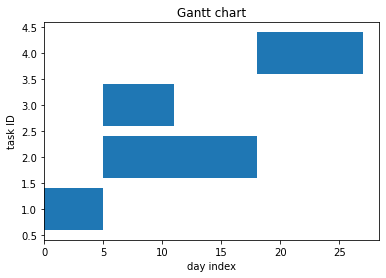

In [27]:
plt.barh(df['ID'], df['Duration actual in days'], left=df['actual start day index'])
plt.ylabel('task ID')
plt.xlabel('day index')
plt.title("Gantt chart");

In [28]:
def calculate_end_date(row):
    return row['Duration actual in days']+row['actual start day index']

In [29]:
df['actual end day index'] = df.apply(lambda row: calculate_end_date(row), axis=1)

In [30]:
df

,ID,successor ID,Duration actual in days,actual start day index,actual end day index
0,1,2,5,0,5
0,1,3,5,0,5
1,2,4,13,5,18
2,3,NaN,6,5,11
3,4,NaN,9,18,27


In [35]:
duration_of_effort_in_days = df['actual end day index'].max()

duration_of_effort_in_days

27

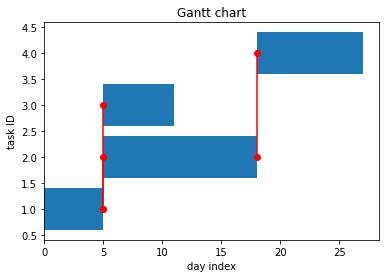

In [32]:
plt.barh(df['ID'], df['Duration actual in days'], left=df['actual start day index'])

# add dependency lines to the Gantt chart

# https://stackoverflow.com/a/61159270/1164295
for row_dict in df.to_dict(orient="records"):
    if pandas.notna(row_dict['successor ID']):
        
        # https://stackoverflow.com/a/35363739/1164295
        plt.plot([row_dict['actual end day index'], row_dict['actual end day index']], 
                 [row_dict['ID'], int(row_dict['successor ID'])], 'ro-')
        
plt.ylabel('task ID')
plt.xlabel('day index')
plt.title("Gantt chart");